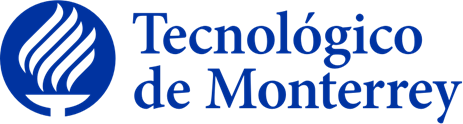

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 6: Modelo Final**

### Domingo 2 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

#### Note: This notebook is still a work in progress

### 1. First, we load the libraries

In [1]:
from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric, ContextualRecallMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from peft import PeftModel
from unsloth import FastLanguageModel
import json
from dotenv import load_dotenv
from deepeval.synthesizer import Synthesizer
from loader.legal_document_loader import LegalDocumentLoader
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.modeling_utils import PreTrainedModel
from deepeval.dataset.golden import Golden
from deepeval.utils import is_confident
from deepeval import login_with_confident_api_key
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import torch
import os
import re


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [10]:
def extract_response(response: str) -> str|None:
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )
    
def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
    
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 650, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)
    
    return extract_response(result[0])

def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict], prompt_template: str) -> list:
    test_cases = []
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        if (golden is Golden):
            datapoint = json.load(golden.model_dump_json())
        
        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases


### 2. Then we extract the env variables

In [2]:
load_dotenv()

True

In [ ]:
url = "https://github.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/raw/main/Avance-4/mexican_laws"

docs = LegalDocumentLoader.load_from_url(url)
path = './tmp'



In [10]:
if not os.path.exists(path):
    os.makedirs(path)

for doc in docs:
    filename = doc['Title'].encode('ascii', 'ignore')
    filename = filename.decode()
    filename = filename.lower().replace(' ', '_') + '.txt'
    
    with open(os.path.join(path,filename), 'w') as f:
        f.write(doc['Text'])
    



In [ ]:
os.removedirs(path)

In [3]:
synth = Synthesizer( model = 'gpt-3.5-turbo', multithreading = False)

list_docs = []

for path, folders, files in os.walk('./tmp'):
    for file in files[:5]:
        if file.endswith('.txt'):
            list_docs.append(f'./tmp/{file}')

synth.generate_goldens_from_docs(
   
    document_paths=list_docs,
    include_expected_output=True,
    chunk_overlap=50,
    num_evolutions = 1,
    max_goldens_per_document=2)

synth.save_as(file_type='json', directory='./synthetic_data')

Output()

Synthetic goldens saved at ./synthetic_data/20240605_203859.json!


'./synthetic_data/20240605_203859.json'

### 3. Let's download the model that was finetuned 

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = 2048,
    device_map='cuda',
    load_in_4bit = True,
)


==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 4070 Laptop GPU. Max memory: 7.996 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:

model = PeftModel.from_pretrained(model, model_id='JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v1')
FastLanguageModel.for_inference(model)

In [6]:
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

### 4. Let's generate a sample prompt from our model 

In [7]:
with open('./synthetic_data/test_set.json', 'r') as f:
    test_set = json.load(f)
    
test_set[:2]

[{'input': '¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?',
  'actual_output': None,
  'expected_output': 'Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.',
  'context': ['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-12-2012\n\nXII. Otros que sean necesarios a juicio del Alto Mando.\n\nFracción adicionada DOF 31-12-2012\n\nArtículo 47.- Para ingresar a la Armada de México se requiere:\n\nI. Ser mexicano por nacimiento;\n\nII. No contar con otra nacionalidad;\n\nFracción reformada DOF 31-12-2012\n\nIII. Estar en pleno goce y ejercicio de los derech

In [8]:
dataset = EvaluationDataset()
dataset.add_test_cases_from_json_file('./synthetic_data/test_set.json',     
    input_key_name="input",
    actual_output_key_name="actual_output",
    expected_output_key_name="expected_output",
    context_key_name="context")

In [ ]:
dataset.test_cases = generate_test_cases(model, tokenizer, test_set, alpaca_based_prompt)
dataset.test_cases

In [13]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

In [14]:
results = evaluate(dataset, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=True, use_cache=True, ignore_errors=True)

Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(




Metrics Summary

  - ❌ Hallucination (score: 1.0, threshold: 0.3, strict: False, evaluation model: gpt-3.5-turbo, reason: The score is 1.00 because the actual output does not align with any of the provided contexts, indicating a high degree of hallucination in the generated content., error: None)
  - ✅ Answer Relevancy (score: 0.8, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The score is 0.80 because the answer provided relevant information about the criteria for entry into the Mexican Navy but included some details about a specific law article that was not directly addressing the question asked., error: None)
  - ✅ Correctness (GEval) (score: 0.938722260951506, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output matches the expected output provided in the input., error: None)

For test case:

  - input: ¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en lo

Results saved in ./test_results as 20240607_201432

Sending a large test run to Confident, this might take a bit longer than usual...

✅ Tests finished! View results on 
]8;id=497607;https://app.confident-ai.com/project/clwwq2efa0002md0cru9ojbi4/unit-tests/clx5d57v3004ahmch17pofkoi/test-cases\https://app.confident-ai.com/project/clwwq2efa0002md0cru9ojbi4/unit-tests/clx5d57v3004ahmch17pofkoi/test-cases]8;;\

[TestResult(success=False, metrics=[<deepeval.metrics.hallucination.hallucination.HallucinationMetric object at 0x7fa30f3d28d0>, <deepeval.metrics.answer_relevancy.answer_relevancy.AnswerRelevancyMetric object at 0x7fa30f3d3c50>, <deepeval.metrics.g_eval.g_eval.GEval object at 0x7fa30f3c7c50>], input='¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?', actual_output='La nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica son criterios que deben cumplirse para ingresar a la Armada de México, según el Artículo 8 de la Ley Orgánica de la Armada de México.', expected_output='Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y po

### 6. Let's test the answer